In [16]:
import pandas as pd
import numpy as np

# Load your new, complete master dataset
file_path = '../data/master_dataset_2011-2025.csv'
master_df = pd.read_csv(file_path)

# --- Historical Ballon d'Or Top 10 Finalists by Season ---
ballon_dor_history = {
    '2024-2025': ['Ousmane Dembele', 'Lamine Yamal', 'Vitinha', 'Raphinha', 'Mohammed Salah', 'Kylian Mbappe', 'Achraf Hakimi', 'Desire Doue', 'Kvicha Kvaratskhelia', 'Nuno Mendes'],
    '2023-2024': ['Rodri', 'Vinícius Júnior', 'Jude Bellingham', 'Dani Carvajal', 'Lautaro Martinez', 'Toni Kroos', 'Kylian Mbappé', 'Harry Kane', 'Phil Foden', 'Lamine Yamal'],
    '2022-2023': ['Lionel Messi', 'Erling Haaland', 'Kylian Mbappé', 'Kevin De Bruyne', 'Rodri', 'Vinícius Júnior', 'Julián Álvarez', 'Victor Osimhen', 'Bernardo Silva', 'Luka Modrić'],
    '2021-2022': ['Karim Benzema', 'Sadio Mané', 'Kevin De Bruyne', 'Robert Lewandowski', 'Mohamed Salah', 'Kylian Mbappé', 'Thibaut Courtois', 'Vinícius Júnior', 'Luka Modrić', 'Erling Haaland'],
    '2020-2021': ['Lionel Messi', 'Robert Lewandowski', 'Jorginho', 'Karim Benzema', 'N\'Golo Kanté', 'Cristiano Ronaldo', 'Mohamed Salah', 'Kevin De Bruyne', 'Kylian Mbappé', 'Gianluigi Donnarumma'],
    '2018-2019': ['Lionel Messi', 'Virgil van Dijk', 'Cristiano Ronaldo', 'Sadio Mané', 'Mohamed Salah', 'Kylian Mbappé', 'Alisson', 'Robert Lewandowski', 'Bernardo Silva', 'Riyad Mahrez'],
    '2017-2018': ['Luka Modrić', 'Cristiano Ronaldo', 'Antoine Griezmann', 'Kylian Mbappé', 'Lionel Messi', 'Mohamed Salah', 'Raphaël Varane', 'Eden Hazard', 'Kevin De Bruyne', 'Harry Kane'],
    '2016-2017': ['Cristiano Ronaldo', 'Lionel Messi', 'Neymar', 'Gianluigi Buffon', 'Luka Modrić', 'Sergio Ramos', 'Kylian Mbappé', 'N\'Golo Kanté', 'Robert Lewandowski', 'Harry Kane'],
    '2015-2016': ['Cristiano Ronaldo', 'Lionel Messi', 'Antoine Griezmann', 'Luis Suárez', 'Neymar', 'Gareth Bale', 'Riyad Mahrez', 'Jamie Vardy', 'Gianluigi Buffon', 'Pepe'],
    '2014-2015': ['Lionel Messi', 'Cristiano Ronaldo', 'Neymar', 'Robert Lewandowski', 'Luis Suárez', 'Thomas Müller', 'Manuel Neuer', 'Eden Hazard', 'Andrés Iniesta', 'Alexis Sánchez'],
    '2013-2014': ['Cristiano Ronaldo', 'Lionel Messi', 'Manuel Neuer', 'Arjen Robben', 'Thomas Müller', 'Philipp Lahm', 'Neymar', 'James Rodríguez', 'Toni Kroos', 'Ángel Di María'],
    '2012-2013': ['Cristiano Ronaldo', 'Lionel Messi', 'Franck Ribéry', 'Zlatan Ibrahimović', 'Neymar', 'Andrés Iniesta', 'Robin van Persie', 'Arjen Robben', 'Gareth Bale', 'Andrea Pirlo'],
    '2011-2012': ['Lionel Messi', 'Cristiano Ronaldo', 'Andrés Iniesta', 'Xavi', 'Radamel Falcao', 'Iker Casillas', 'Andrea Pirlo', 'Didier Drogba', 'Robin van Persie', 'Zlatan Ibrahimović'],
    '2010-2011': ['Lionel Messi', 'Cristiano Ronaldo', 'Xavi', 'Andrés Iniesta', 'Wayne Rooney', 'Luis Suárez', 'Diego Forlán', 'Samuel Eto\'o', 'Iker Casillas', 'Neymar']
}

# Create the target variable column (1 for a top candidate, 0 for everyone else)
master_df['Top_Candidate'] = 0
for season, players in ballon_dor_history.items():
    master_df.loc[(master_df['Season'] == season) & (master_df['Player'].isin(players)), 'Top_Candidate'] = 1

print("Historical target variable 'Top_Candidate' created successfully.")
print("Total number of top candidates in the entire dataset:", master_df['Top_Candidate'].sum())

Historical target variable 'Top_Candidate' created successfully.
Total number of top candidates in the entire dataset: 133


C:\Users\akash\AppData\Local\Temp\ipykernel_6232\212853944.py:6: DtypeWarning: Columns (38,57) have mixed types. Specify dtype option on import or set low_memory=False.
  master_df = pd.read_csv(file_path)


In [19]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report

# --- Prepare Data for the Model ---
# Convert UCL_Progress to a numerical ranking
progress_mapping = {
    'W': 1, 'F': 2, 'SF': 3, 'QF': 4,
    'R16': 5, 'GR': 6, 'Did Not Qualify': 7
}
# Use .str.strip() to remove any whitespace from the 'UCL_Progress' column
master_df['UCL_Progress_Rank'] = master_df['UCL_Progress'].str.strip().map(progress_mapping).fillna(7)

# Define the features to use (using the correct column names from our merge)
features_to_use = [
    'Age', 'Min_league', 'Gls_league', 'Ast_league', 'xG_player', 'xAG',
    'Gls_ucl', 'Ast_ucl', 'Min_ucl', 'Rk_team', 'Pts',
    'UCL_Progress_Rank'
]
# Clean up column names in the DataFrame to be safe
master_df.columns = master_df.columns.str.strip() 
X = master_df[features_to_use].fillna(0)
y = master_df['Top_Candidate']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nData prepared and split successfully!")


# --- Train and Evaluate the Model ---
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
model = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_weight, random_state=42)
model.fit(X_train, y_train)
print("Final Ballon d'Or model trained successfully on historical data!")

predictions = model.predict(X_test)
report = classification_report(y_test, predictions, target_names=['Not a Candidate (0)', 'Top Candidate (1)'])

print("\n--- Final Model Evaluation Report ---")
print(report)

KeyError: 'UCL_Progress'

In [14]:
# --- Get a ranked list of all players based on your model's predictions ---

# 1. Get the raw prediction probabilities for the "Top Candidate" class
contender_scores = model.predict_proba(X)[:, 1] 

# 2. Add these scores to your master DataFrame
master_df['Contender_Score'] = contender_scores

# 3. Sort the DataFrame to see who the model ranks highest
top_players_ranked = master_df.sort_values(by='Contender_Score', ascending=False)

# 4. Display the top 25 players according to your model
print("--- Model's Top 25 Ranked Players Across All Seasons ---")

# --- CORRECTED: Replaced 'Gls' with 'Gls_ucl' ---
display(top_players_ranked[[
    'Season', 'Player', 'Squad', 'Gls_league', 'Gls_ucl', 'UCL_Progress', 'Contender_Score'
]].head(25))

--- Model's Top 25 Ranked Players Across All Seasons ---


,Season,Player,Squad,Gls_league,Gls_ucl,UCL_Progress,Contender_Score
16453,2011-2012,Lionel Messi,Barcelona,50.0,0.0,Did Not Qualify,0.999981
18767,2015-2016,Luis Suárez,Barcelona,40.0,0.0,Did Not Qualify,0.999979
18192,2014-2015,Cristiano Ronaldo,Real Madrid,48.0,0.0,Did Not Qualify,0.999969
14047,2022-2023,Erling Haaland,Manchester City,36.0,0.0,Did Not Qualify,0.999937
19167,2016-2017,Lionel Messi,Barcelona,37.0,0.0,Did Not Qualify,0.999908
16997,2012-2013,Lionel Messi,Barcelona,46.0,0.0,Did Not Qualify,0.999902
31795,2023-2024,Kylian Mbappé,Paris S-G,27.0,0.0,Did Not Qualify,0.999876
11310,2017-2018,Kevin De Bruyne,Manchester City,8.0,0.0,Did Not Qualify,0.999859
16009,2010-2011,Cristiano Ronaldo,Real Madrid,40.0,0.0,Did Not Qualify,0.999854
24065,2024-2025,Lamine Yamal,Barcelona,9.0,0.0,Did Not Qualify,0.999852


<Figure size 1200x800 with 0 Axes>

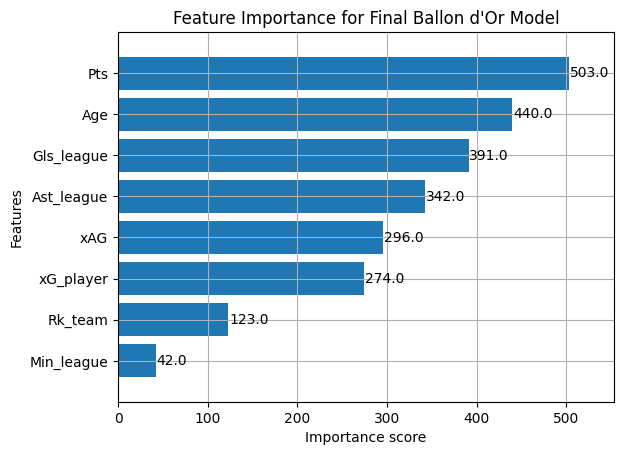

In [8]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot the feature importances to see what the model values most
plt.figure(figsize=(12, 8))
xgb.plot_importance(model, max_num_features=15, height=0.8)
plt.title('Feature Importance for Final Ballon d\'Or Model')
plt.show()

In [32]:
import pandas as pd

try:
    # Load your final master dataset
    file_path = '../data/master_dataset_2011-2025.csv'
    master_df = pd.read_csv(file_path)

    # Define the stages we want to see (based on FBref's codes)
    # W = Winner, SF = Semifinals
    target_stages = ['W', 'SF'] 

    # Filter the DataFrame to include only players from teams that reached these stages
    top_teams_df = master_df[master_df['UCL_progress'].isin(target_stages)].copy()

    # Sort the results by Season and then by UCL Progress to group them nicely
    # We create a custom order to ensure Winners appear before Semifinalists
    top_teams_df['UCL_progress'] = pd.Categorical(top_teams_df['UCL_progress'], categories=['W', 'SF'], ordered=True)
    sorted_df = top_teams_df.sort_values(by=['Season', 'UCL_progress'])

    # Display only the relevant columns as requested
    print("--- Players from UCL Winning and Semi-Finalist Teams ---")
    display(sorted_df[[
        'Season',
        'Player',
        'Squad',
        'UCL_progress'
    ]])

except FileNotFoundError:
    print(f"ERROR: The file '{file_path}' was not found. Please ensure it exists.")
except Exception as e:
    print(f"An error occurred: {e}")

--- Players from UCL Winning and Semi-Finalist Teams ---


,Season,Player,Squad,UCL_progress
